# Demand Matrix and Price optimization
The goal of this notebook is to create built the demand matrix for CatBoost and FAM model and test the price optimization.

The demand matrix is an N-dimension matrix storing the information of the different demands obtained by combining feature values. In our case the demand matrix will be a vector with the different demands for different prices. Depending on the problem additional dimensions as week or channel can be added.

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model, model_selection
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
import xgboost
from xgboost import XGBRegressor
import catboost
from catboost import CatBoostRegressor


We first import the dataset:

In [272]:
data = pd.read_csv('../Data/TFM_Hdataset_Gtrends.csv', index_col=0)
data['Date'] = pd.to_datetime(data['Date'])

conditions = [(data['Year']!= 2019) & (data['Year']!= 2021),
              (data['Year']== 2019),
              (data['Year']!= 2019)]

vals = [np.sin(2*np.pi*data['Week']/52),
        np.sin(2*np.pi*data['Week']/53),
        np.sin(2*np.pi*data['Week']/50)
       ]

vals2 = [np.cos(2*np.pi*data['Week']/52),
        np.cos(2*np.pi*data['Week']/53),
        np.cos(2*np.pi*data['Week']/50)
       ]
data['Week_sin'] = np.select(conditions,vals)
data['Week_cos'] = np.select(conditions,vals2)

In [273]:
data = data[['Description', 'Seasonality', 'Year', 'Week_sin','Week_cos', 'Channel',
       'WSSI Category', 'LIMITED EDITION STYLES', 'Originals', 'Source',
       'gender', 'style', 'prev_sales2', 'prev_sales3',
       'prev_sales4', 'Price', 'Discount','Date','prev_mean_price',
       'RRP', 'Markdown', 'Cost', 'CategoryCluster',
       'ProductCluster','sales']]

We apply CatBoost (we can do that because the processing time is really low):

In [274]:

data_p = data.loc[data['CategoryCluster']=='Cluster 1']    
data_s = data_p.drop(['CategoryCluster','Date','prev_mean_price'], axis=1)
categorical_features_indices = np.where(data_s.dtypes != np.float64)[0]

X = data_s[(data_p['Date']<'01-01-2021')].values
T = data_s[(data_p['Date']>='01-01-2021')].values 

X_train,y_train = X[:,:-1], X[:,-1]
X_test,y_test = T[:,:-1], T[:,-1] 

mod_cb = CatBoostRegressor(iterations=54, depth=11, learning_rate=0.1, od_type= "Iter", loss_function='RMSE')
mod_cb = mod_cb.fit(X_train,y_train,cat_features=categorical_features_indices,eval_set=(X_test, y_test),plot=True)
y_hat = mod_cb.predict(X_test)
y_hat_m = mod_cb.predict(X_train)

score = r2_score(y_test,y_hat)
score2 = mean_squared_error(y_test,y_hat)
score3 = mean_absolute_error(y_test,y_hat)

score_m = r2_score(y_train,y_hat_m)
score2_m = mean_squared_error(y_train,y_hat_m)
score3_m = mean_absolute_error(y_train,y_hat_m)




MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 208.4468100	test: 74.7297872	best: 74.7297872 (0)	total: 241ms	remaining: 12.8s
1:	learn: 191.9781361	test: 69.3719223	best: 69.3719223 (1)	total: 462ms	remaining: 12s
2:	learn: 177.1143026	test: 64.6013450	best: 64.6013450 (2)	total: 691ms	remaining: 11.8s
3:	learn: 163.7305795	test: 60.4502023	best: 60.4502023 (3)	total: 718ms	remaining: 8.97s
4:	learn: 151.6690857	test: 56.5512073	best: 56.5512073 (4)	total: 745ms	remaining: 7.3s
5:	learn: 141.4740651	test: 53.2850452	best: 53.2850452 (5)	total: 988ms	remaining: 7.9s
6:	learn: 131.8810887	test: 50.2759264	best: 50.2759264 (6)	total: 1.22s	remaining: 8.22s
7:	learn: 123.3786851	test: 48.0347116	best: 48.0347116 (7)	total: 1.5s	remaining: 8.6s
8:	learn: 115.6913389	test: 45.9627786	best: 45.9627786 (8)	total: 1.78s	remaining: 8.89s
9:	learn: 108.6870680	test: 44.4106766	best: 44.4106766 (9)	total: 2.04s	remaining: 9s
10:	learn: 103.0945803	test: 42.9260539	best: 42.9260539 (10)	total: 2.31s	remaining: 9.02s
11:	learn: 97.004

### Demand Matrix CatBoost
We first select a row of data and we extract the mean price as a reference. We then create an array of different prices:

In [275]:
for row in [318]:
    G_1 = data.iloc[row][['Description', 'Seasonality', 'Year', 'Week_sin','Week_cos', 'Channel',
       'WSSI Category', 'LIMITED EDITION STYLES', 'Originals', 'Source',
       'gender', 'style', 'prev_sales2', 'prev_sales3',
       'prev_sales4', 'Price', 'Discount',
       'RRP', 'Markdown', 'Cost',
       'ProductCluster','sales']].values
    p_0_1 = data[(data['Description']==G_1[0])&(data['Seasonality']==G_1[1])&(data['Channel']==G_1[5])]['Price'].mean()
    p_p_1 = p_0_1
    p_1 = np.zeros(15)
    p_1[0] = 0
    p_1[1] = p_0_1
    for j in range(1,14):
        p_1[1+j] = p_0_1+p_p_1*j
        
print(G_1[19])    
print(p)    

1.2400000000000002
[ 0.          1.81402404  3.62804809  5.44207213  7.25609618  9.07012022
 10.88414427 12.69816831 14.51219236 16.3262164  18.14024045 19.95426449
 21.76828854 23.58231258 25.39633663 27.21036067 29.02438471 30.83840876
 32.6524328  34.46645685 36.28048089 38.09450494 39.90852898 41.72255303
  0.        ]


In [276]:
data.iloc[318]

Description                  Footwear Cleaner
Seasonality                              CONT
Year                                     2017
Week_sin                             0.120537
Week_cos                             0.992709
Channel                   Retail - Full Price
WSSI Category                       Shoe Care
LIMITED EDITION STYLES                    0.0
Originals                                 0.0
Source                                   NONE
gender                                 Unisex
style                                    Care
prev_sales2                               0.0
prev_sales3                               0.0
prev_sales4                               0.0
Price                                3.907528
Discount                               0.1369
Date                      2017-01-08 00:00:00
prev_mean_price                           0.0
RRP                                  4.166666
Markdown                             0.122238
Cost                              

We now predict the demand for the different array of prices (rest of the features stay the same)

[ 87.43702033 123.84710685 174.82905652 174.82905652 174.82905652
 174.82905652 174.82905652 174.82905652 174.82905652 174.82905652
 174.82905652 174.82905652 174.82905652 174.82905652 174.82905652]


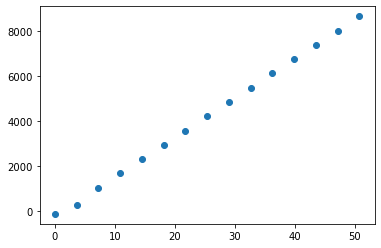

In [277]:
i=0
G_y_1 = np.zeros(15)

for prices in p_1:
    G_1[15] = prices
    dem = G_1[:-1]
    G_y_1[i] = mod_cb.predict(dem)
    i += 1
print(G_y_1)
G_r_1 = G_y_1*(p_1 - G_1[19])
plt.scatter(p_1,G_r_1) 

### Demand Matrix for Model for Footwear Cleaner
We repeat the same for the FAM model

In [278]:
def model6b(X,w):
    p_new = pnew2(X,w)
    beta = w[1]*X[1] + w[2]*X[2] + w[5]*X[3]
    y = np.exp(w[0] - beta*(np.log(p_new)))
    return y


def pnew2(X,w):
    p = w[3]*X[3] + w[4]*X[4] + w[6]*X[0]
    return p

In [279]:
#We take the historical mean price and cost of the product
p_0 = data[(data['Description']=='Footwear Cleaner')&(data['Channel']=='Retail - Full Price')]['Price'].mean()
c_0 = data[(data['Description']=='Footwear Cleaner')&(data['Channel']=='Retail - Full Price')]['Cost'].mean()
print(p_0)
print(c_0)
# We create different prices for this product 7over and under the mean price
p_p = p_0/2
p = np.zeros(25)
G_y = np.zeros(25)
p[2] = p_0
for j in range(1,22):
        p[2+j] = p_0+p_p*j
for j in[1,2]:                
        p[2-j] = p_0-p_p*j

print(p)    

3.6280480893316787
1.240000000000003
[ 0.          1.81402404  3.62804809  5.44207213  7.25609618  9.07012022
 10.88414427 12.69816831 14.51219236 16.3262164  18.14024045 19.95426449
 21.76828854 23.58231258 25.39633663 27.21036067 29.02438471 30.83840876
 32.6524328  34.46645685 36.28048089 38.09450494 39.90852898 41.72255303
  0.        ]


C:\Users\JAELFR~1\AppData\Local\Temp/ipykernel_12364/1845824579.py:4: RuntimeWarning: invalid value encountered in log
  y = np.exp(w[0] - beta*(np.log(p_new)))


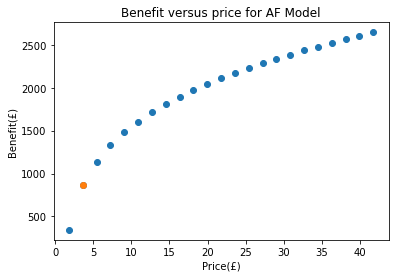

In [280]:
#We simulate new row (we take it from our dataset)
G = data.iloc[318][['Price','Week_sin','Week_cos','Discount','prev_mean_price']].values
w = [ 5.91370823, -1.7049693,   1.35986708, -0.25820421,  0.02712276, -3.30790766, 0.29491122]
i=0

#We predict the demand for the different prices
for prices in p:
    G_p = G
    G_p[0] = prices    
    y = model6b(G_p,w)
    G_y[i] = y
    i += 1

#We calculate and plot the benefit
ben = G_y*(p - c_0) 
plt.scatter(p,ben)   
plt.scatter(p_0,ben[2])   
plt.title('Benefit versus price for AF Model')
plt.xlabel('Price(£)')
plt.ylabel('Benefit(£)')

plt.savefig('../Images/optim.png')

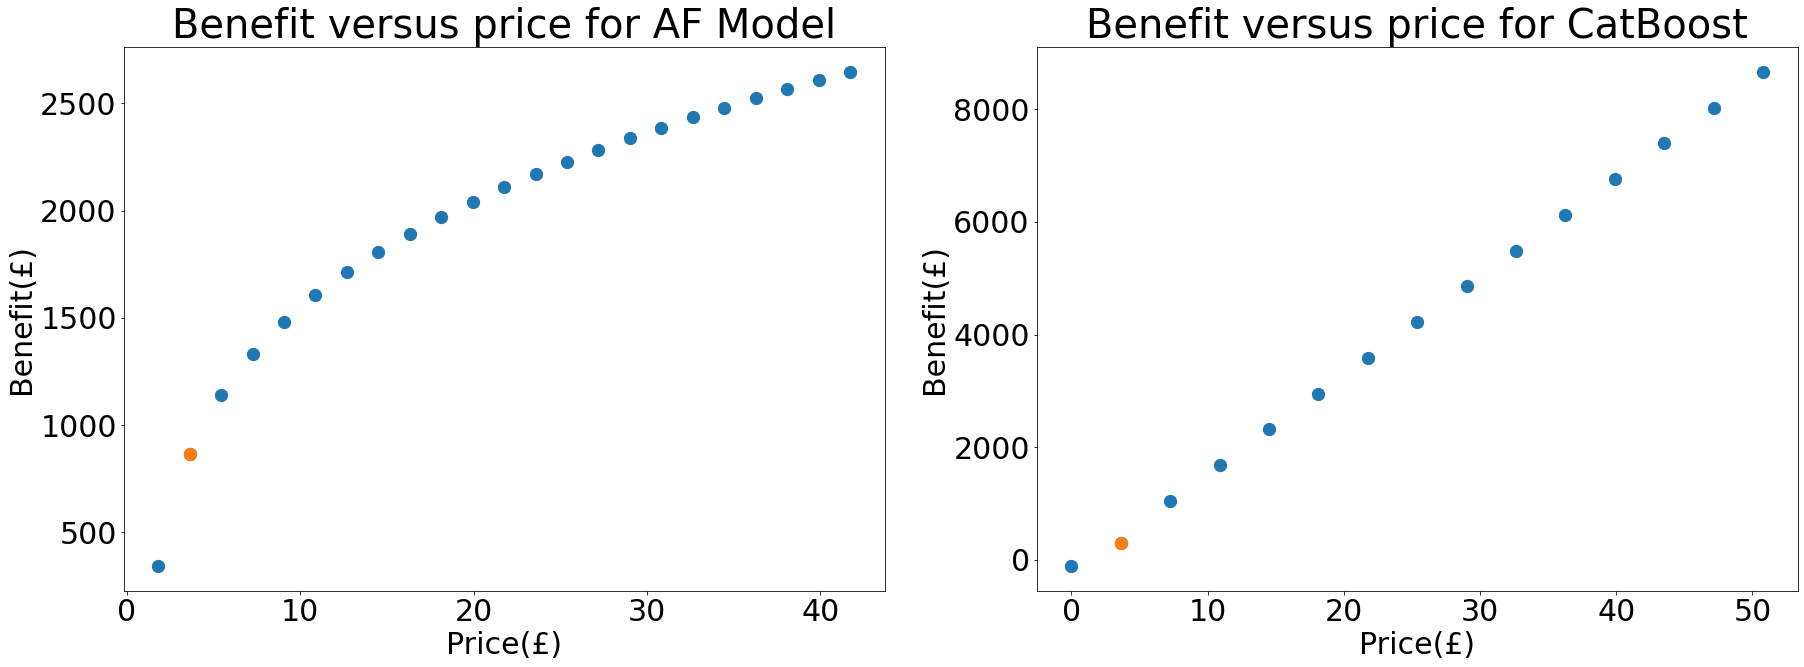

In [281]:
fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(30,10),gridspec_kw={'width_ratios': [1, 1]})

ax1.scatter(p,ben,s=150)   
ax1.scatter(p_0,ben[2],s=150)   
ax1.set_title('Benefit versus price for AF Model', fontsize=40)
ax1.set_xlabel('Price(£)', fontsize=30)
ax1.set_ylabel('Benefit(£)', fontsize=30)
ax1.tick_params('both', labelsize=30)


ax2.scatter(p_1,G_r_1,s=150)   
ax2.scatter(p_0_1,G_r_1[1],s=150)   
ax2.set_title('Benefit versus price for CatBoost', fontsize=40)
ax2.set_xlabel('Price(£)', fontsize=30)
ax2.set_ylabel('Benefit(£)', fontsize=30)
ax2.tick_params('both', labelsize=30)

plt.savefig('../Images/optim.png')